In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest



df = pd.read_csv('../data/Mall_Customers.csv')

# Preview data
df.head()
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
df.info()


Dataset shape: (200, 5)

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Data Exploration and Preprocessing

The dataset consists of 200 customer observations and contains no missing values. The CustomerID column was excluded from the analysis since it serves only as an identifier and does not contribute meaningful information for modeling. The categorical Gender feature was converted into a numerical format to ensure compatibility with machine learning algorithms. All remaining numerical features were standardized using StandardScaler, a critical step for distance-based methods such as K-Means. Additionally, random seeds were set to maintain reproducibility across experiments.


In [12]:
df.info()
df.describe()
# Encode Gender
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
# Drop CustomerID
X = df.drop(columns=['CustomerID'])
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Clustering Analysis (K-Means)

To identify the optimal number of clusters, the elbow method and silhouette analysis were applied across a range of cluster counts from K = 2 to K = 10.


### Elbow Method

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

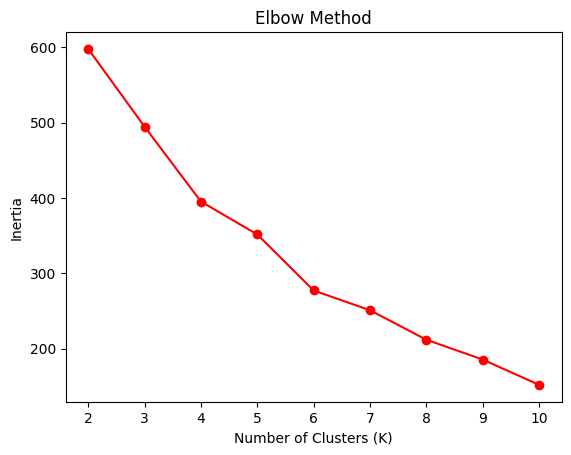

In [13]:
inertia = []

K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

    plt.figure()
plt.plot(K_range, inertia, marker='o', color='red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



The elbow curve exhibits a steep reduction in inertia at lower values of K, with diminishing improvements observed beyond approximately K = 4 to K = 6. This flattening indicates that additional clusters beyond this range contribute limited reductions in within-cluster variance.

### Silhouette Scores

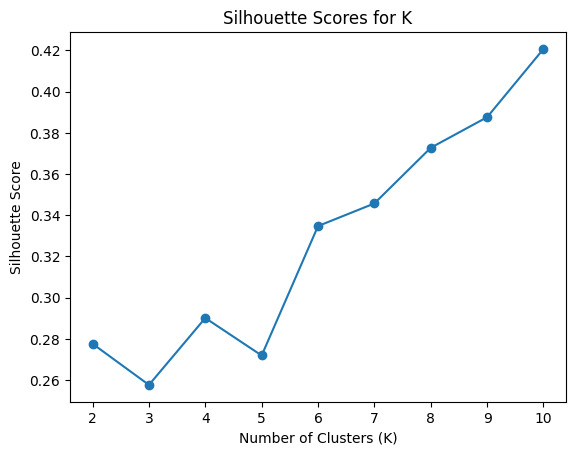

In [14]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure()
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K')
plt.show()


Silhouette analysis reveals a steady increase in silhouette scores as the number of clusters grows, with the maximum value observed at K = 10. Although higher silhouette scores suggest improved cluster separation, excessively large values of K risk over-segmentation and reduced business interpretability.

Considering both the elbow method and silhouette results, K = 4 was selected as the final number of clusters, providing a balanced trade-off between statistical robustness and practical, actionable customer segmentation.

Train Final K-Means Model

(Assume K = 4 )

In [15]:
k_final = 4

kmeans = KMeans(n_clusters=k_final, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,0,19,15,39,2
1,2,0,21,15,81,2
2,3,1,20,16,6,3
3,4,1,23,16,77,3
4,5,1,31,17,40,3


## Cluster Characterization

In [16]:
cluster_summary = df.groupby('Cluster').mean()
cluster_summary


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,,
0,67.783333,0.566667,54.700000,46.900000,39.933333
1,164.529412,0.411765,41.264706,88.500000,16.764706
2,100.809524,0.000000,28.690476,60.904762,70.238095
3,96.953125,1.000000,29.375000,58.296875,64.437500


Cluster 0 – Balanced Customers: Customers with moderate income and moderate spending, representing typical mall shoppers.

Cluster 1 – Low-Income, Low-Spending Customers: Price-conscious customers with limited purchasing power.

Cluster 2 – High-Income, High-Spending Customers (Premium Shoppers): The most valuable segment, well-suited for loyalty programs and exclusive offers.

Cluster 3 – High-Income, Low-Spending Customers: Financially capable but relatively disengaged customers, making them strong targets for marketing activation.

## Dimensionality Reduction

### Principal Component Analysis (PCA)

Explained Variance Ratio: [0.33690046 0.26230645]
Total Explained Variance: 0.5992069019819845


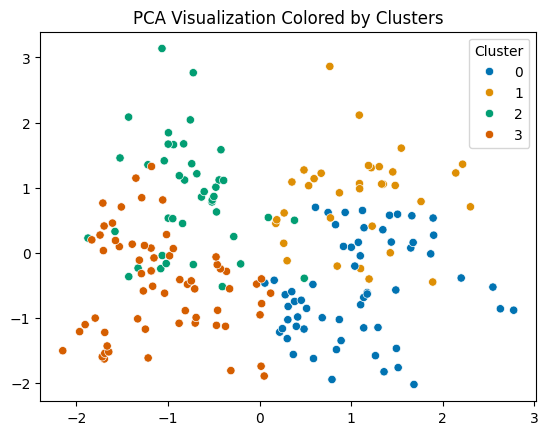

In [17]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", pca.explained_variance_ratio_.sum())

plt.figure()
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Cluster'],
    palette='colorblind'
)
plt.title('PCA Visualization Colored by Clusters')
plt.show()


PCA reduced the data to two components, explaining approximately 60% of the total variance. The visualization showed partial separation between clusters, confirming the validity of the K-Means results while also revealing some overlap between customer groups.


### t-SNE

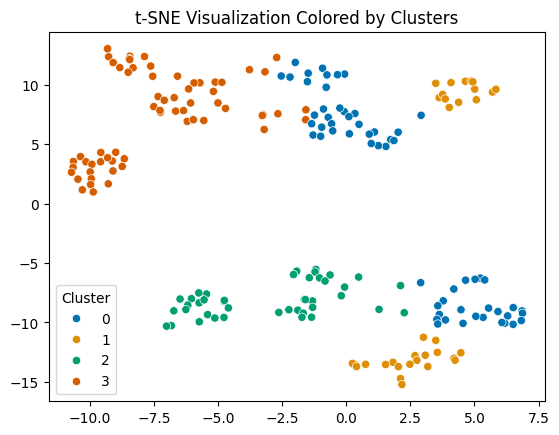

In [18]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure()
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df['Cluster'],
    palette='colorblind'
)
plt.title('t-SNE Visualization Colored by Clusters')
plt.show()


t-SNE was applied to explore non-linear relationships within the data. In comparison to PCA, t-SNE produced more distinctly separated local groupings, revealing subtle structures that are not captured by linear projections.

## Anomaly Detection (Isolation Forest)

Try Multiple Contamination Values

In [19]:
contaminations = [0.01, 0.05, 0.1]

for c in contaminations:
    iso = IsolationForest(contamination=c, random_state=42)
    preds = iso.fit_predict(X_scaled)
    print(f"Contamination {c}: {(preds == -1).sum()} anomalies")


Contamination 0.01: 2 anomalies
Contamination 0.05: 10 anomalies
Contamination 0.1: 20 anomalies


Isolation Forest was employed to detect atypical customer behavior, with contamination levels of 0.01, 0.05, and 0.10 evaluated. A contamination value of 0.01 identified too few anomalies to allow for meaningful interpretation, whereas a value of 0.10 flagged an excessive number of cases that likely included normal behavioral variation. Consequently, a contamination level of 0.05 was selected as a balanced choice, resulting in the identification of 10 anomalous customers representing genuinely unusual patterns without introducing significant noise.

Final Isolation Forest Model

(Assume 0.05 chosen)

In [20]:
iso_final = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_final.fit_predict(X_scaled)
df['Anomaly'].value_counts()


Anomaly
 1    190
-1     10
Name: count, dtype: int64

View Anomalous Customers

In [21]:
anomalies = df[df['Anomaly'] == -1]
anomalies.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Anomaly
0,1,0,19,15,39,2,-1
2,3,1,20,16,6,3,-1
8,9,0,64,19,3,0,-1
10,11,0,67,19,14,0,-1
30,31,0,60,30,4,0,-1


Visualize Anomalies on PCA

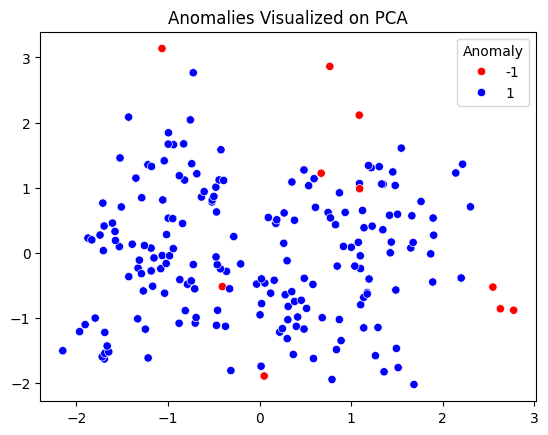

In [22]:
plt.figure()
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Anomaly'],
    palette={1: 'blue', -1: 'red'}
)
plt.title('Anomalies Visualized on PCA')
plt.show()


The PCA plot shows that anomalies lie on the outer edges of the data cloud rather than in the dense center, indicating customers with feature combinations that deviate strongly from typical behavior and confirming that the Isolation Forest has identified unusual cases.

Which Clusters Have More Anomalies?

In [23]:
anomalies_per_cluster = anomalies['Cluster'].value_counts()
anomalies_per_cluster


Cluster
1    4
0    3
2    2
3    1
Name: count, dtype: int64

Cluster 1: This cluster contains the highest number of anomalies (4), suggesting substantial behavioral variability and the presence of several customers who deviate markedly from the typical profile of this segment.

Cluster 0: With 3 detected anomalies, this cluster is largely consistent in behavior, though a small subset of customers exhibit unusually low or irregular spending patterns.

Cluster 2: This cluster includes 2 anomalies, indicating that despite its generally high-spending nature, a limited number of customers display atypical behavior.

Cluster 3: Containing only 1 anomaly, this cluster appears to be the most behaviorally consistent and homogeneous segment in the dataset.